# Data mining - summarization

## Skenario
```
Dataset: indosum
```

1. Standard summarize & evaluation

In [1]:
import pickle
import tempfile
import shutil
import os

import pandas as pd
import networkx as nx
import json
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (5,5)

from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals

import nltk
from indosum.models import AbstractSummarizer
from indosum.models.unsupervised import *
from TextRank4Keyword import *

from pprint import pprint
from pythonrouge.pythonrouge import Pythonrouge

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

factory1 = StopWordRemoverFactory()
stopword = factory1.create_stop_word_remover()
# from indosum.create_splits import *
# nltk.download('punkt')

# https://github.com/miso-belica/sumy

In [2]:
#nltk.download('punkt')
"""
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
"""
1
np.array([1] * 3)

array([1, 1, 1])

In [52]:
# " ".join(l1)

# serialize obj to file
def dumpToPickle(obj, fname='file.pkl'):
    # Open a file and use dump()
    with open(fname, 'wb') as file:
        # A new file will be created
        pickle.dump(obj, file)

def loadPickle(fname):
    fo = open(fname, "rb")
    print("Unpickling...")
    # Unpickle the objects
    return pickle.load(fo)

def toFile(fname, cnt):
    return open(fname, "w").write(cnt)

# paragraph p, sentence s, word w
def paragraphToPlain(l1):
    text = ""
    for p in l1:
        par = ""
        for s in p:
            se = ""
            for w in s:
                se += w + " "
            par += se+" "
        text += par
    return text

def read_jsonl(path, name='test', encoding='utf-8', lower=True, remove_puncts=True,
               replace_digits=True, stopwords_path=None):
#     _log.info('Reading %s JSONL file from %s', name, path)
#     if SAVE_FILES:
#         _run.add_resource(path)
    stopwords = None if stopwords_path is None else read_stopwords(stopwords_path)

    with open(path, encoding=encoding) as f:
        for line in f:
            yield Document.from_mapping(
                json.loads(line.strip()), lower=lower, remove_puncts=remove_puncts,
                replace_digits=replace_digits, stopwords=stopwords)

## 1. Data

In [4]:
# jsonObj = pd.read_json("/media/data1/_S2/indosum/train.01.jsonl", lines=True) # 14k rows
jsonObj = pd.read_json("/media/data1/_S2/indosum/train.01.100.jsonl", lines=True) # sample
jsonObj

,category,gold_labels,id,paragraphs,source,source_url,summary
0,tajuk utama,"[[False, True], [True, True], [False, False, F...",1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dokter, R...",cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...,"[[Dokter, Lula, Kamal, yang, merupakan, selebr..."
1,teknologi,"[[False, False, False, False], [False, True, T...",1509072914-dua-smartphone-zenfone-baru-tawarka...,"[[[Selfie, ialah, salah, satu, tema, terpanas,...",dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...,"[[Asus, memperkenalkan, , ZenFone, generasi, ..."
2,hiburan,"[[True], [True], [False, False], [False], [Fal...",1510613677-songsong-visit-2020-bengkulu-perkua...,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dinas, Pa...",cnn indonesia,https://www.cnnindonesia.com/gaya-hidup/201711...,"[[Dinas, Pariwisata, Provinsi, Bengkulu, kemba..."
3,tajuk utama,"[[True, True], [False, False, False], [True], ...",1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,"[[[Merdeka.com, -, Indonesia, Corruption, Watc...",merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...,"[[Indonesia, Corruption, Watch, (, ICW, ), mem..."
4,tajuk utama,"[[False, True], [True, True, True], [False], [...",1503039338-pembagian-sepeda-usai-upacara-penur...,"[[[Merdeka.com, -, Presiden, Joko, Widodo, (, ...",merdeka,https://www.merdeka.com/peristiwa/usai-upacara...,"[[Jokowi, memimpin, upacara, penurunan, bender..."
...,...,...,...,...,...,...,...
95,tajuk utama,"[[False, False], [False, False], [False], [Fal...",1484474411-reklamasi-jakarta-untuk-siapa,"[[[Jakarta, ,, CNN, Indonesia, -, -, Banjir, y...",cnn indonesia,http://m.cnnindonesia.com/nasional/20170110202...,"[[Permasalahan, tenggelamnya, daratan, di, Jak..."
96,showbiz,"[[True, True], [True, True], [True, False], [F...",1500161400-selena-gomez-akui-punya-fetish-di-l...,"[[[Jakarta, ,, CNN, Indonesia, -, -, Selena, G...",cnn indonesia,https://www.cnnindonesia.com/hiburan/201707131...,"[[Selena, Gomez, baru, mengaku, bahwa, dia, me..."
97,teknologi,"[[False, False], [False], [False, False], [Tru...",1499749200-angin-meningkatkan-peran-perempuan-...,"[[[Permasalahan, masih, minimnya, jumlah, pere...",dailysocial.id,https://dailysocial.id/post/rencana-angin-meni...,"[[Angel, Investment, Network, Indonesia, (, AN..."
98,olahraga,"[[False, True], [False, False], [False, False]...",1505764276-thailand-raih-juara-piala-aff-u-18-...,"[[[Tim, nasional, (, timnas, ), Thailand, berh...",goal indonesia,http://www.goal.com/id-ID/news/1387/nasional/2...,"[[Thailand, menaklukkan, Malaysia, dengan, sko..."


In [50]:
paragraphToPlain( eval( str(jsonObj['paragraphs'][2]) ) )

'Jakarta , CNN Indonesia - - Dinas Pariwisata Provinsi Bengkulu kembali menggelar kegiatan Bimbingan Teknis ( Bimtek ) SDM Kepariwisataan dalam menyongson " Visit 2020 Wonderful Bengkulu " .  Kegiatan yang berlangsung pada 8 hingga 10 November kemarin tersebut sebagai bagian dari upaya Pemerintah Provinsi Bengkulu dalam  Hadir sebagai pemateri kegiatan pada 8 - 10 November itu adalah Plt.  Asdep Strategi Pemasaran Pariwisata Nusantara , Deputi Bidang Pengembangan Pemasaran Pariwisata Nusantara Hariyanto serta perwakilan dari Deputi Bidang Pengembangan Kelembagaan Kementerian Pariwisata , Faizal .  Kepala Dinas Pariwisata Provinsi Bengkulu Yudi Satria mengatakan , kegiatan Bimtek diikuti 250 peserta yang terdiri dari aparatur Pemerintah Provinsi , ASN Kabupaten / Kota , Kelompok Sadar Wisata serta pihak terkait sektor pariwisata di Bengkulu .  " Kegiatan ini dimaksudkan untuk memberikan pembekalan kepada peserta di bidang kepariwisataan , " ujar Yudi Satria .  Ia mengatakan , Pemprov te

In [5]:
path = "/media/data1/_S2/indosum/train.01.100.jsonl"
docs = read_jsonl(path)
ddoc = []
for doc in docs:
    ddoc.append(doc)

In [6]:
ddoc[0].sentences[0].words

['jakarta',
 'cnn',
 'indonesia',
 'dokter',
 'ryan',
 'thamrin',
 'yang',
 'terkenal',
 'lewat',
 'acara',
 'dokter',
 'oz',
 'indonesia',
 'meninggal',
 'dunia',
 'pada',
 'jumat',
 '0',
 '0',
 'dini',
 'hari']

In [7]:
#jsonObj.describe()
1

1

In [8]:
jsonObj["category"]

0     tajuk utama
1       teknologi
2         hiburan
3     tajuk utama
4     tajuk utama
         ...     
95    tajuk utama
96        showbiz
97      teknologi
98       olahraga
99    tajuk utama
Name: category, Length: 100, dtype: object

In [9]:
set(jsonObj["source"])

{'antaranews',
 'cnn indonesia',
 'dailysocial.id',
 'goal indonesia',
 'juara.net',
 'kumparan',
 'merdeka',
 'poskotanews',
 'rimanews',
 'suara'}

In [10]:
set(jsonObj["category"])

{'hiburan', 'olahraga', 'showbiz', 'tajuk utama', 'teknologi'}

In [11]:
"""

#jsonObj['paragraphs'][0]
p1 = eval(str(jsonObj['paragraphs'][0]))
text = paragraphToPlain(p1)
text
"""
1

1

In [12]:
# LANGUAGE = "english"
# SENTENCES_COUNT = 10

# sample api = https://github.com/miso-belica/sumy
"""
def summarize(string, LANGUAGE = "english", SENTENCES_COUNT = 10):
    #url = "https://en.wikipedia.org/wiki/Automatic_summarization"
    #parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))
    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    parser = PlaintextParser.from_string(string, Tokenizer(LANGUAGE))
    stemmer = Stemmer(LANGUAGE)

    summarizer = Summarizer(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)

    sums = []
    
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        print(sentence)
        sums.append(str(sentence))
    
    return string, sums
"""
# summarize(text, LANGUAGE = "english", SENTENCES_COUNT = 10)
1

1

# 2. Summarization & keyword extraction

In [81]:
# mapIndexesToSentences({0,1,3}, ["a","b","c","d","e"])
def mapIndexesToSentences(idxs, sentences):
    return [sentences[i] for i in idxs]

def create_model(damping=0.85, tol=1e-6, max_iter=100):
    return TextRank(damping_factor=damping, tol=tol, max_iter=max_iter)

def run_summarization(model: AbstractSummarizer, path, size=5, withKeywordExtract=False):
    results = {
        "doc": [],
        "summaries": []
    }
    models = []
    docs = read_jsonl(path)
    for doc in docs:
        results["doc"].append(doc)
        summary = set(model.summarize(doc, size=size))
        
        # append models
        models.append(model)
        
        sent_id = 0
        for para in doc.paragraphs:
            for sent in para:
                sent.pred_label = sent_id in summary
                sent_id += 1
        results["summaries"].append({
            "index": summary,
            "mapped": mapIndexesToSentences(summary, [str(s) for s in doc.sentences])
        })
        
        # get keyword extraction
        
#         break
        #print(json.dumps(doc.to_dict(), sort_keys=True))
    return results, docs, models

def summarize(path, model = None):
    model = create_model() if model==None else create_model()
    
    return run_summarization(model, path)

# evaluate
def eval_summaries(summaries, docs, logger=None, encoding='utf-8', delete_temps=True):
    references = []
    hypotheses = []
    for summary, doc in zip(summaries, docs):
        refs = [[' '.join(sent) for sent in doc.summary]]
        hyp = [' '.join(doc.sentences[idx].words) for idx in summary]
        references.append(refs)
        hypotheses.append(hyp)

    assert len(references) == len(hypotheses), 'Number of references and hypotheses mismatch'

    ref_dirname = tempfile.mkdtemp()
    hyp_dirname = tempfile.mkdtemp()
    
    for doc_id, (refs, hyp) in enumerate(zip(references, hypotheses)):
        # Write references
        for rid, ref in enumerate(refs):
            ref_filename = os.path.join(ref_dirname, f'{doc_id}.{rid}.txt')
            with open(ref_filename, 'w', encoding=encoding) as f:
                print('\n'.join(ref), file=f)
        # Write hypothesis
        hyp_filename = os.path.join(hyp_dirname, f'{doc_id}.txt')
        with open(hyp_filename, 'w', encoding=encoding) as f:
            print('\n'.join(hyp), file=f)

    rouge = Pythonrouge(
        peer_path=hyp_dirname, model_path=ref_dirname, stemming=False, ROUGE_L=True,
        ROUGE_SU4=False)
    score = rouge.calc_score()
    print('ROUGE scores: %s', score)

    if delete_temps:
        print('Deleting temporary files and directories')
        shutil.rmtree(ref_dirname)
        shutil.rmtree(hyp_dirname)

    return score

def getKeywords(text, n=10):
    tr4w = TextRank4Keyword()
    tr4w.analyze(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
    return tr4w.get_keywords(n), tr4w

def getKeywordsFromArrs(arr):
    ret = []
    processes = []
    for e in arr:
        text = stopword.remove(str(e))
        kws, tr4w = getKeywords(text, n=10)
        ret.append(kws)
        processes.append(tr4w)
    
    return ret, processes

def createWordCloud(text, w = 640, h = 480):
    wordcloud = WordCloud(width=w, height=h).generate(text)

    # Display the generated image:
    # the matplotlib way:

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    return wordcloud

def showGraph(G, **kwargs):
    nx.draw(G, **kwargs)
#     nx.draw_random(G)
    nx.draw_circular(G)
#     nx.draw_spectral(G)
    # when drawing to an interactive display. Note that you may need to issue a Matplotlib

#     plt.show()

In [14]:
# p1 = "/media/data1/_S2/indosum/train.01.jsonl"
p1 = "/media/data1/_S2/indosum/train.01.100.jsonl"
results, docs, models = summarize(p1)
results

{'doc': [<indosum.models.data.Document at 0x7fe71c9b1f70>,
 'summaries': [{'index': {0, 1, 2, 8, 15},
   'mapped': ['jakarta cnn indonesia dokter ryan thamrin yang terkenal lewat acara dokter oz indonesia meninggal dunia pada jumat 0 0 dini hari\t\t\t0',
    'dokter lula kamal yang merupakan selebriti sekaligus rekan kerja ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu\t\t\t1',
    'lula menuturkan sakit itu membuat ryan mesti vakum dari semua kegiatannya termasuk menjadi pembawa acara dokter oz indonesia\t\t\t1',
    'dia juga tak tahu penyakit apa yang diderita ryan\t\t\t0',
    'ryan thamrin terkenal sebagai dokter yang rutin membagikan tips dan informasi kesehatan lewat tayangan dokter oz indonesia\t\t\t0']},
  {'index': {6, 15, 26, 34, 37},
   'mapped': ['satu keunikan yang membuat zd000kl lebih ‘ unggul’ dari zenfone 0 selfie pro adalah dukungan tiga slot kartu dua untuk sim dan satu lagi buat microsd storage dapat diekspansi \xa0 sampai \xa0 0 tb\t\t\t0',
    'ke

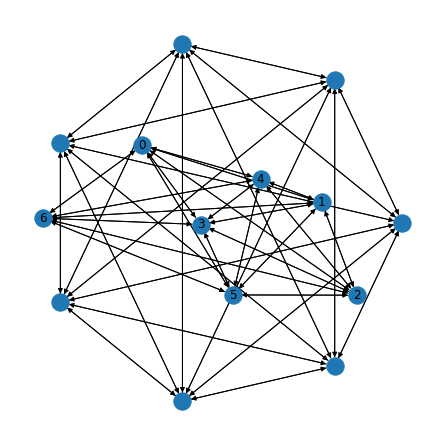

In [83]:
mpl.rcParams['figure.figsize'] = (6,6)
showGraph(models[0].G, with_labels=True)

In [15]:
results["summaries"][1:3]

[{'index': {6, 15, 26, 34, 37},
  'mapped': ['satu keunikan yang membuat zd000kl lebih ‘ unggul’ dari zenfone 0 selfie pro adalah dukungan tiga slot kartu dua untuk sim dan satu lagi buat microsd storage dapat diekspansi \xa0 sampai \xa0 0 tb\t\t\t0',
   'kedua perangkat sudah mulai dipasarkan mulai tanggal 00 november dan sampai \xa0 tanggal 00 november nanti paket penjualan turut dibundel bersama ‘ gong yoo special gift box’ serta speaker bluetooth khusus zenfone 0 selfie pro – selama persediaan masih ada\t\t\t0',
   'mereka adalah asus zenfone 0 selfie pro zd000kl dan zenfone 0 selfie zd000kl\t\t\t1',
   'di sana asus mencantumkan sistem duopixel 00mp berisi kombinasi sepasang sensor sony exmor rs imx000 0,0 µm 00 megapixel dengan aperture f/0.0 ditambah sensor omnivision 0000 0,00 µm f/0.0 yang memiliki lensa wide-angle 000 derajat sehingga kamera bisa merangkul objek dua kali lebih banyak – memungkinkan anda ber-selfie bersama kawan ataupun keluarga tanpa bantuan monopod\t\t\t0',


In [16]:
indexes = [ l['index'] for l in results["summaries"] ]
#indexes

# 3. Evaluation

In [17]:
evaluation = eval_summaries(indexes, results["doc"])
evaluation

ROUGE scores: %s {'ROUGE-1-R': 0.56682, 'ROUGE-1-P': 0.36121, 'ROUGE-1-F': 0.43842, 'ROUGE-2-R': 0.40593, 'ROUGE-2-P': 0.25748, 'ROUGE-2-F': 0.31319, 'ROUGE-L-R': 0.54614, 'ROUGE-L-P': 0.34797, 'ROUGE-L-F': 0.42251}
Deleting temporary files and directories


{'ROUGE-1-R': 0.56682,
 'ROUGE-1-P': 0.36121,
 'ROUGE-1-F': 0.43842,
 'ROUGE-2-R': 0.40593,
 'ROUGE-2-P': 0.25748,
 'ROUGE-2-F': 0.31319,
 'ROUGE-L-R': 0.54614,
 'ROUGE-L-P': 0.34797,
 'ROUGE-L-F': 0.42251}

In [43]:
df = pd.DataFrame({
    "metric": evaluation.keys(),
    "value": evaluation.values(),
})
df.to_csv("dummy/2022-0529-rouge.csv")
df

,metric,value
0,ROUGE-1-R,0.56682
1,ROUGE-1-P,0.36121
2,ROUGE-1-F,0.43842
3,ROUGE-2-R,0.40593
4,ROUGE-2-P,0.25748
5,ROUGE-2-F,0.31319
6,ROUGE-L-R,0.54614
7,ROUGE-L-P,0.34797
8,ROUGE-L-F,0.42251


In [19]:
# dump
dumpToPickle({
    "results": results, 
    #"docs": docs, 
    "models": models,
    "evaluation": evaluation
}, 'dummy/2022-0525-ex-textrank-100.pkl')
# }, '2022-0525-ex-textrank.pkl')

In [20]:
# load dump
# fname = './dummy/2022-0525-ex-textrank.pkl'
fname = './dummy/2022-0525-ex-textrank-100.pkl'
presults = loadPickle(fname)

evaluation = presults['evaluation']

Unpickling...


In [21]:
presults.keys()

dict_keys(['results', 'models', 'evaluation'])

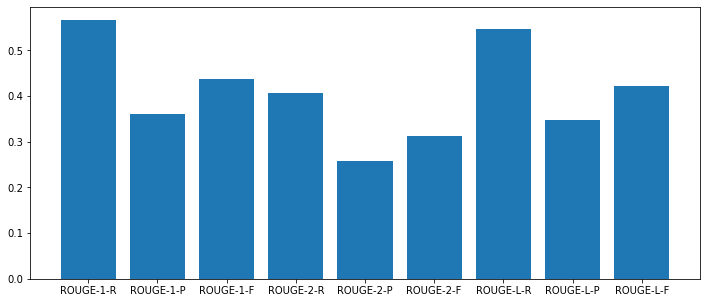

In [22]:
mpl.rcParams['figure.figsize'] = (12,5)
plt.bar(evaluation.keys(), evaluation.values(), width=0.8)
plt.show()

In [23]:
presults['results'].keys()

dict_keys(['doc', 'summaries'])

In [24]:
len(presults['results']['doc']), len(presults['results']['summaries'])

(100, 100)

In [25]:
prs = list(presults['results']['doc'][0])
str(prs[0]), str(prs[1])

('jakarta cnn indonesia dokter ryan thamrin yang terkenal lewat acara dokter oz indonesia meninggal dunia pada jumat 0 0 dini hari\t\t\t0\ndokter lula kamal yang merupakan selebriti sekaligus rekan kerja ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu\t\t\t1',
 'lula menuturkan sakit itu membuat ryan mesti vakum dari semua kegiatannya termasuk menjadi pembawa acara dokter oz indonesia\t\t\t1\nkondisi itu membuat ryan harus kembali ke kampung halamannya di pekanbaru riau untuk menjalani istirahat\t\t\t1')

In [51]:
sst = str(presults['results']['doc'][2])
sst

'jakarta cnn indonesia dinas pariwisata provinsi bengkulu kembali menggelar kegiatan bimbingan teknis bimtek sdm kepariwisataan dalam menyongson visit 0000 wonderful bengkulu\t\t\t1\n\nkegiatan yang berlangsung pada 0 hingga 00 november kemarin tersebut sebagai bagian dari upaya pemerintah provinsi bengkulu dalam\t\t\t1\n\nhadir sebagai pemateri kegiatan pada 0 00 november itu adalah plt.\t\t\t0\nasdep strategi pemasaran pariwisata nusantara deputi bidang pengembangan pemasaran pariwisata nusantara hariyanto serta perwakilan dari deputi bidang pengembangan kelembagaan kementerian pariwisata faizal\t\t\t0\n\nkepala dinas pariwisata provinsi bengkulu yudi satria mengatakan kegiatan bimtek diikuti 000 peserta yang terdiri dari aparatur pemerintah provinsi asn kabupaten kota kelompok sadar wisata serta pihak terkait sektor pariwisata di bengkulu\t\t\t0\n\nkegiatan ini dimaksudkan untuk memberikan pembekalan kepada peserta di bidang kepariwisataan ujar yudi satria\t\t\t0\n\nia mengatakan pe

In [27]:
sst = stopword.remove(sst)
sst

'jakarta cnn indonesia dokter ryan thamrin terkenal acara dokter oz indonesia meninggal dunia jumat 0 0 hari\t\t\t0\ndokter lula kamal selebriti rekan ryan menyebut kawannya sakit setahun lalu\t\t\t1\n\nlula sakit ryan mesti vakum kegiatannya pembawa acara dokter oz indonesia\t\t\t1\nkondisi ryan kampung halamannya pekanbaru riau menjalani istirahat\t\t\t1\n\nsetahu orangnya sehat tahun dengar sakit\t\t\t0\nkarena sakitnya pulang pekanbaru jenguk susah\t\t\t0\nbarangkali istirahat jakarta susah isirahatnya lula cnnindonesia.com jumat 0 0\t\t\t0\n\nlula mengenal ryan aktif berkarier televisi mengaku membesuk ryan lantaran lokasi jauh\t\t\t0\ndia penyakit diderita ryan\t\t\t0\n\nitu jenguk dijenguk juga\t\t\t0\nenggak berat ryan\t\t\t0\n\nwalau setahun menderita sakit lula penyebab kematian dr oz indonesia itu\t\t\t0\nmeski mendengar kabar menyebut penyebab ryan meninggal jatuh kamar mandi\t\t\t0\n\n“ barangkali penyakit berbeda penyebab kematiannya beda penyakit sebelumnya\t\t\t0\nkita 

In [28]:
x, m = getKeywords(sst, n=10)
x

{'ryan': 3.902280839094647,
 'dokter': 2.763444990221701,
 'penyakit': 2.6894028372435717,
 'lula': 2.4219163746247783,
 'indonesia': 1.994772952979202,
 'sakit': 1.9103297606962983,
 'penyebab': 1.8647831972711475,
 'oz': 1.7373896464494134,
 'tahun': 1.4682715390313255,
 'dia': 1.4635207031770245,
 'kesehatan': 1.4429233589602886,
 'pekanbaru': 1.4073040620975923}

In [29]:
# get all keyword & embed
docsKeywords, textks = getKeywordsFromArrs(presults['results']['doc'])

In [30]:
docsKeywords[2], docsKeywords[3], docsKeywords[4]

({'pariwisata': 6.705129744155251,
  'bengkulu': 4.3443139493528555,
  'kegiatan': 2.9270232374870777,
  'bimtek': 2.8645560817055764,
  'sdm': 2.404906186880726,
  'salah': 2.28600223449713,
  'promosi': 2.2182946914827406,
  'yudi': 2.2016111520757984,
  'sektor': 2.0764985408853747,
  'acara': 2.05381027609076,
  'provinsi': 2.0459044431628106,
  'memiliki': 2.005759961022271},
 {'icw': 3.005371434725087,
  'kpk': 2.9001265017587476,
  'ktp': 2.569343188929464,
  'saksi': 2.0531277576420015,
  'kunci': 1.9980625592878667,
  'momentum': 1.697527712830662,
  'korupsi': 1.6917999397567618,
  'kematian': 1.5577319677411787,
  'meninggalnya': 1.5073083428851315,
  'negatif': 1.341229644362672,
  'kejanggalan': 1.3208210163413878,
  'kita': 1.313981885618102},
 {'adat': 6.6873594219253745,
  'sepeda': 3.243885887701278,
  'presiden': 2.0680285317643827,
  'bendera': 1.8059647539326016,
  'pakaian': 1.7339578546022811,
  'dayak': 1.5627935985630352,
  'upacara': 1.5473024281099446,
  'sore

In [36]:
presults['results']['doc'][0].__dict__

{'paragraphs': [<indosum.models.data.Paragraph at 0x7fe71c5aa190>,
 'summary': <indosum.models.data.Paragraph at 0x7fe71c5ae970>,
 'category': 'tajuk utama',
 'source': 'cnn indonesia',
 'source_url': 'https://www.cnnindonesia.com/hiburan/20170804120703-234-232443/lula-kamal-dokter-ryan-thamrin-sakit-sejak-setahun-lalu/',
 'id_': '1501893029-lula-kamal-dokter-ryan-thamrin-sakit-sejak-setahun',
 'lower': True,
 'remove_puncts': True,
 'replace_digits': True,
 'stopwords': None}

In [42]:
dfkw = pd.DataFrame({
    "doc": [ r.id_[0:8] for r in presults['results']['doc']],
    "keywords": [ ", ".join(kw.keys()) for kw in docsKeywords],
})
dfkw.to_csv("dummy/2022-0529-kw.csv")
dfkw

,doc,keywords
0,15018930,"ryan, dokter, penyakit, lula, indonesia, sakit..."
1,15090729,"selfie, zenfone, asus, 0,0, zd000kl, kamera, h..."
2,15106136,"pariwisata, bengkulu, kegiatan, bimtek, sdm, s..."
3,15027068,"icw, kpk, ktp, saksi, kunci, momentum, korupsi..."
4,15030393,"adat, sepeda, presiden, bendera, pakaian, daya..."
...,...,...
95,14844744,"jakarta, tanah, penurunan, reklamasi, pemerint..."
96,15001614,"gomez, lagu, album, bernyanyi, fetish, memilik..."
97,14997492,"perempuan, teknologi, indonesia, startup, star..."
98,15057642,"thailand, malaysia, gol, menit, tim, serangan,..."


In [31]:
list( np.array([[1,1],[2,2]]).flatten() )

[1, 1, 2, 2]

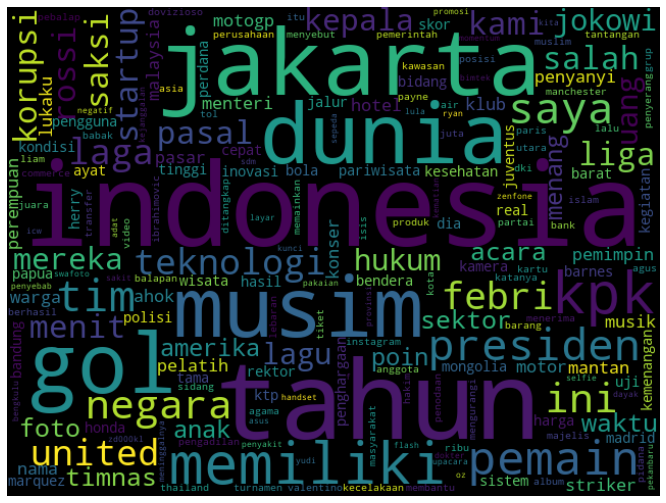

In [53]:
allKws = [list(kw.keys()) for kw in docsKeywords]
allKws = list( np.array(allKws).flatten() )
allKws = " ".join(allKws)
mpl.rcParams['figure.figsize'] = (16,9)
wck = createWordCloud(allKws)

In [59]:
# normalized frequency
dfwck = pd.DataFrame({
    "keywords": wck.words_.keys(),
    "index_norm": wck.words_.values(),
})
dfwck.to_csv("./dummy/2022-0529-wck.csv")
dfwck

,keywords,index_norm
0,indonesia,1.000000
1,tahun,0.888889
2,jakarta,0.611111
3,gol,0.500000
4,musim,0.500000
...,...,...
195,adat,0.055556
196,sepeda,0.055556
197,pakaian,0.055556
198,dayak,0.055556


In [33]:
len(textks), textks[0:10]

(100,
  <TextRank4Keyword.TextRank4Keyword at 0x7fe71ac91730>])

In [34]:
textks[0].last

{'vocab': OrderedDict([('jakarta', 0),
              ('cnn', 1),
              ('indonesia', 2),
              ('dokter', 3),
              ('ryan', 4),
              ('thamrin', 5),
              ('acara', 6),
              ('oz', 7),
              ('meninggal', 8),
              ('dunia', 9),
              ('jumat', 10),
              ('0', 11),
              ('hari', 12),
              ('lula', 13),
              ('kamal', 14),
              ('selebriti', 15),
              ('menyebut', 16),
              ('kawannya', 17),
              ('sakit', 18),
              ('setahun', 19),
              ('lalu', 20),
              ('mesti', 21),
              ('vakum', 22),
              ('kegiatannya', 23),
              ('pembawa', 24),
              ('kondisi', 25),
              ('halamannya', 26),
              ('pekanbaru', 27),
              ('riau', 28),
              ('menjalani', 29),
              ('istirahat', 30),
              ('setahu', 31),
              ('sehat', 32),
     